In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# Plotting tools

Below, we define some useful plotting functions to assist us.

In [71]:
def stem_plot(ax, x, y, title = '', xlabel = '', ylabel = '', ylim = None):
    ax.stem(x, y)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    ax.grid()

# Low rank approximation

## Plotting the ACF

Let $k:\mathbb{N}\to\mathbb{R}$ be an autocovariance function (ACF). Given a max time lag $T$, we begin by plotting the values
$$
    [k(-T),\dots,k(-1),k(0),k(1),\dots,k(T)] = [k(T),\dots,k(1),k(0),k(1),\dots,k(T)]
$$
We denote the total length of this sequence by $N\coloneqq 2T+1$. Here, we will focus on the simple example of the RBF kernel given by
$$
    k(\tau) \coloneqq \exp\left(-\frac{\tau^2}{2l^2}\right)
$$
for some parameter $l$.

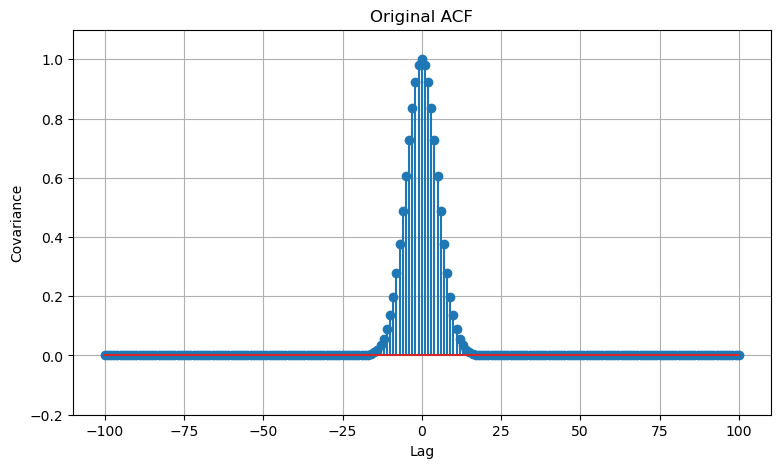

In [72]:
T = 100             # Maximum time lag
N = 2 * T + 1       # Number of points in the ACF

# Define RBF ACF
lengthscale = 5     # Lengthscale of the ACF
k = [0] * N         # Initialize the ACF
for tau in range(T + 1):
    k[T + tau] = k[T - tau] = np.exp(-0.5 * (tau / lengthscale) ** 2)

lags = np.arange(-T, T+1)

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, lags, k, "Original ACF", "Lag", "Covariance", (-0.2, 1.1))

## Compute the DFT of the ACF

Our first task is to take the DFT of the ACF $k$ defined previously. To preserve evenness of the input signal, we must shift the ACF vector appropriately. Namely, we will take the DFT of the following sequence:
$$
    [k(0),k(1),\dots,k(T),k(T),\dots,k(1)]
$$
We will call this the *shifted* ACF, as opposed to the original *centered* one. This ensures that the DFT is real-valued and of the form
$$
\begin{equation}
    S(m) = k(0) + 2 \sum_{t=1}^T k(t) \cos\left(2\pi\frac{m}{N}t\right) 
\end{equation}
$$
In addition, the DFT vector is symmetric:
$$
    S = [S(0),S(1),\dots,S(T),S(T),\dots,S(1)]
$$
As a first step, let us understand how the shifting operations `np.fft.fftshift` and `np.fft.ifftshift` work.

In [73]:
# Toy example to understand shifting operation
arr1 = np.array([0, 1, 2, 2, 1])
arr2 = np.array([2, 1, 0, 1, 2])
print(f'Shift: {arr1} --> {np.fft.fftshift(arr1)}')
print(f'Inverse shift: {arr2} --> {np.fft.ifftshift(arr2)}')

Shift: [0 1 2 2 1] --> [2 1 0 1 2]
Inverse shift: [2 1 0 1 2] --> [0 1 2 2 1]


Hence, we must 
1. Inverse-shift the ACF to get the shifted ACF.
2. Take the DFT, which yields a shifted vector. Note that we must explicitly take the real part to further manipulate it.
3. Shift the DFT for plotting.

<!-- For 3, note that $S(m)$ corresponds to frequency $2\pi m/N$ -->
> TODO: explain frequency axis


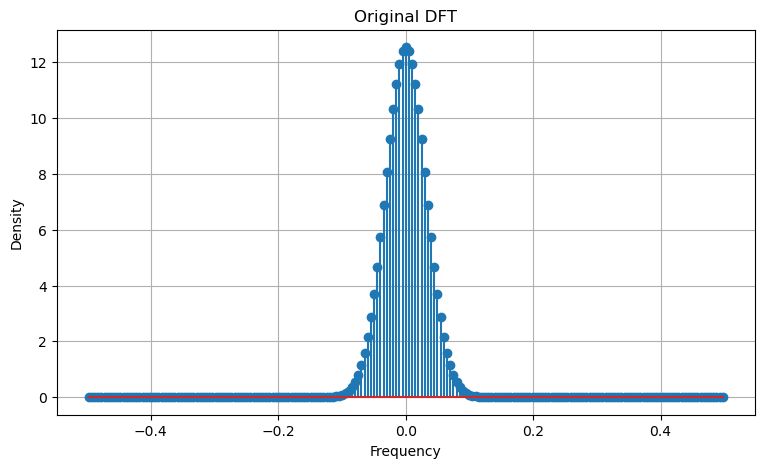

In [74]:
k_shifted = np.fft.ifftshift(k)                                         # Shifted ACF          
spectrum_shifted = np.real(np.fft.fft(k_shifted))                       # Shifted DFT
spectrum = np.fft.fftshift(spectrum_shifted)                            # Centered DFT
Omega = np.fft.fftshift(np.fft.fftfreq(N))                              # Centered frequencies

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, Omega, spectrum, "Original DFT", "Frequency", "Density")

As a sanity check, let us compare the result above with the explicit DFT formula (1).

In [75]:
S = np.fft.fftshift([k_shifted[0] + 2 * sum([k_shifted[t] * np.cos(2 * np.pi * m * t / N) for t in range(1, T + 1)]) for m in range(N)])
print('Mean difference:', np.mean(spectrum - S))

Mean difference: 5.340345876801345e-16


## Get top modes

Recall that the DFT has $T+1$ unique values $S(0),\dots,S(T)$. We will keep the DC component $S(0)$ and the next $r$ largest values. The rest we will set to $0$.

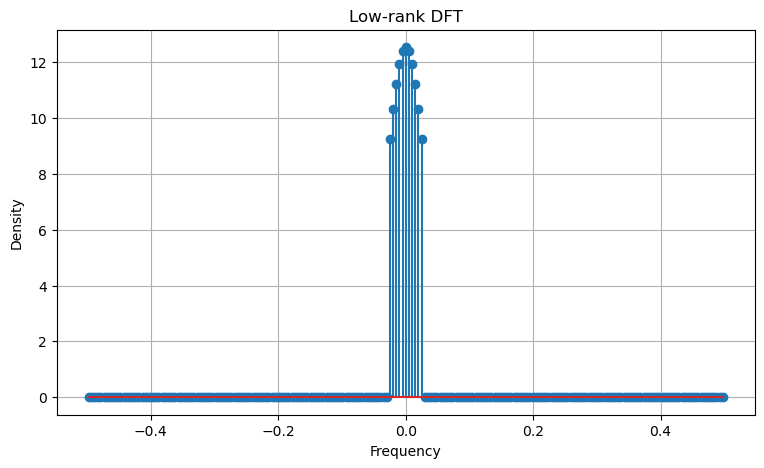

In [76]:
r = 5       # Number of modes

# Mask the spectrum
lr_spectrum_shifted = spectrum_shifted[1:].copy()                                   # Remove DC component
lr_spectrum_shifted[lr_spectrum_shifted < np.sort(lr_spectrum_shifted)[-2*r]] = 0   # Set all but the top 2r values to 0. The 2 serves to preserve symmetry.
lr_spectrum_shifted = np.append(spectrum_shifted[0], lr_spectrum_shifted)           # Always keep the DC component

# Shift the spectrum and plot
lr_spectrum = np.fft.fftshift(lr_spectrum_shifted)

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, Omega, lr_spectrum, "Low-rank DFT", "Frequency", "Density")


## Reconstruct low-rank ACF

The masked DFT yields a low-rank ACF $k_\text{LR}$, which we can obtain by taking the inverse DFT.

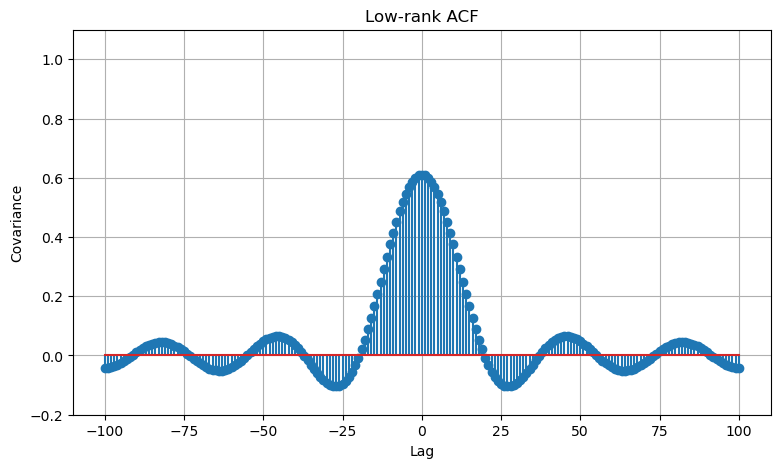

In [77]:
k_lr = np.fft.fftshift(np.real(np.fft.ifft(lr_spectrum_shifted)))   # Low-rank ACF

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, lags, k_lr, "Low-rank ACF", "Lag", "Covariance", (-0.2, 1.1))

Finally, we plot all pieces side-by-side for visualization.

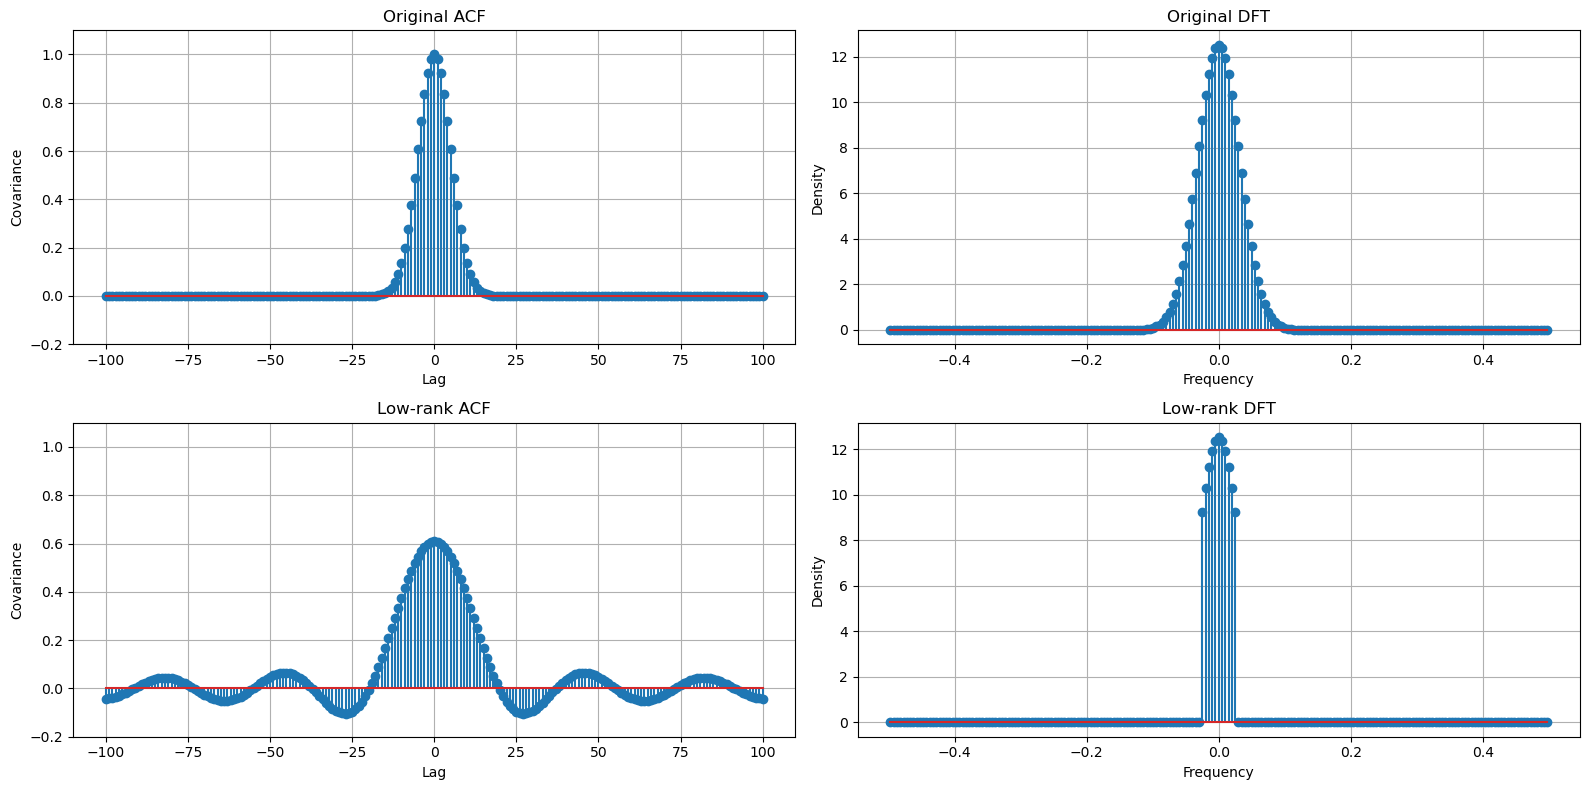

In [78]:
fig, ax = plt.subplots(2, 2, figsize=(16, 8))

stem_plot(ax[0][0], lags, k, "Original ACF", "Lag", "Covariance", (-0.2, 1.1))
stem_plot(ax[0][1], Omega, spectrum, "Original DFT", "Frequency", "Density")
stem_plot(ax[1][1], Omega, lr_spectrum, "Low-rank DFT", "Frequency", "Density")
stem_plot(ax[1][0], lags, k_lr, "Low-rank ACF", "Lag", "Covariance", (-0.2, 1.1))
plt.tight_layout()

# Sparse approximation

Notice the discrepancy between the original ACF and its low-rank approximation. Evidently, we were unable to capture the peaks at small lags. To mitigate this issue, we will fit the residual ACF $k_\text{res} = k-k_\text{LR}$ with a moving average ACF of order $q$. Let us begin by plotting the residual ACF.

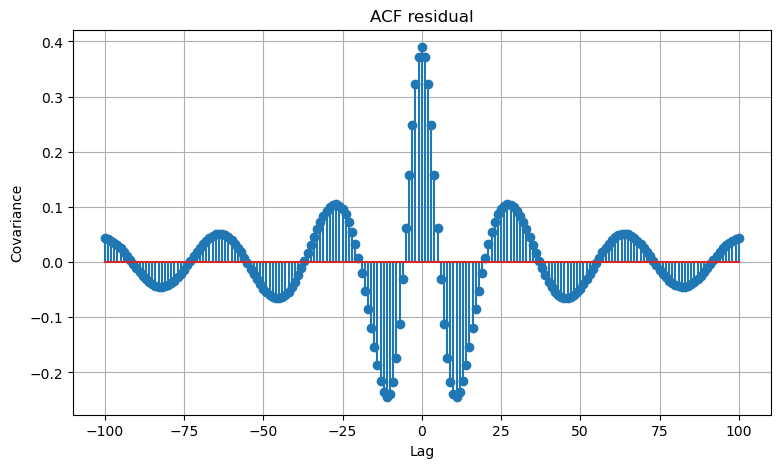

In [79]:
k_res = k - k_lr  # Residual ACF

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, lags, k_res, "ACF residual", "Lag", "Covariance")

Recall that the $\text{MA}(q)$ ACF, under parameter $\theta=(\theta_0,\dots,\theta_q)$, is given by
$$
    k_\text{MA}(\tau;\theta) = \sum_{m=0}^{q-\tau} \theta_m \theta_{m+\tau}
$$
Our goal is to find the $\theta$ that best fits the residual ACF in $\ell_2$ distance:
$$
    \theta^* = \argmin_{\theta\in\mathbb{R}^{q+1}} \Vert k_\text{res}-k_\text{MA}(\cdot;\theta) \Vert_2
$$
This then yields the *sparse* ACF $k_\text{S} = k_\text{MA}(\cdot;\theta^*)$.

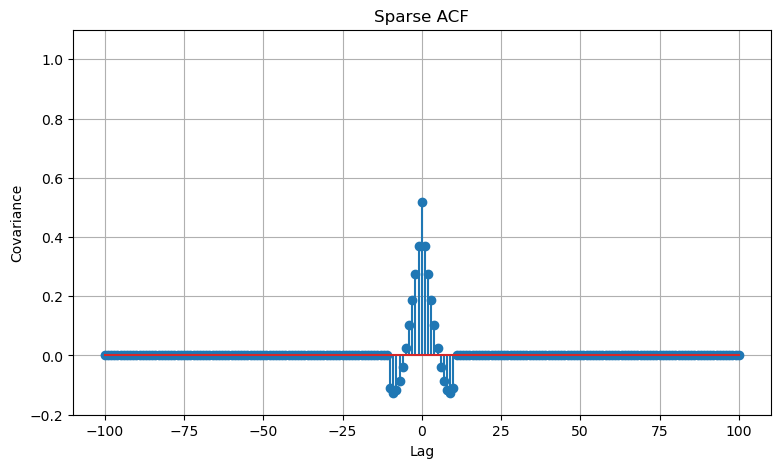

In [80]:
def MA_ACF(theta):
    """
    Compute the MA(q) ACF under parameter theta
    """
    q = len(theta) - 1
    return [sum([theta[k] * theta[k+t] for k in range(q-t+1)]) for t in range(q+1)]


def MA_approx(k, q):
    """
    Parameters
    ----------
    k : Centered ACF.
    q : MA model order.

    Returns
    -------
    The best (in l2) MA(q) approximation of k (centered).
    """
    T = (len(k) - 1) // 2

    # Truncate the ACF to match the MA(q) ACF support
    k_trunc = np.array(k[T:T+q+1])

    # We initialize with the square root of the original ACF to preserve the scaling (the MA ACF essentially squares the parameters). Note that we must also preserve the sign.
    signs = np.sign(k_trunc)
    init = np.sqrt(np.abs(k_trunc)) * signs

    # Solve the least squares problem. 
    sol = least_squares(lambda theta: MA_ACF(theta) - k_trunc, init)
    
    k_MA_trunc = MA_ACF(sol.x)
    return np.concatenate([np.zeros(T-q), k_MA_trunc[q:0:-1], k_MA_trunc, np.zeros(T-q)])

q = 10
k_s = MA_approx(k_res, q)

fig, ax = plt.subplots(figsize=(9, 5))
stem_plot(ax, lags, k_s, "Sparse ACF", "Lag", "Covariance", (-0.2, 1.1))

# Combining: low-rank + sparse

The last step is to combine the low-rank and sparse components. The reconstructed approximate ACF will be the result of adding both kernels: $k_\text{rec} = k_\text{LR} + k_\text{S}$.

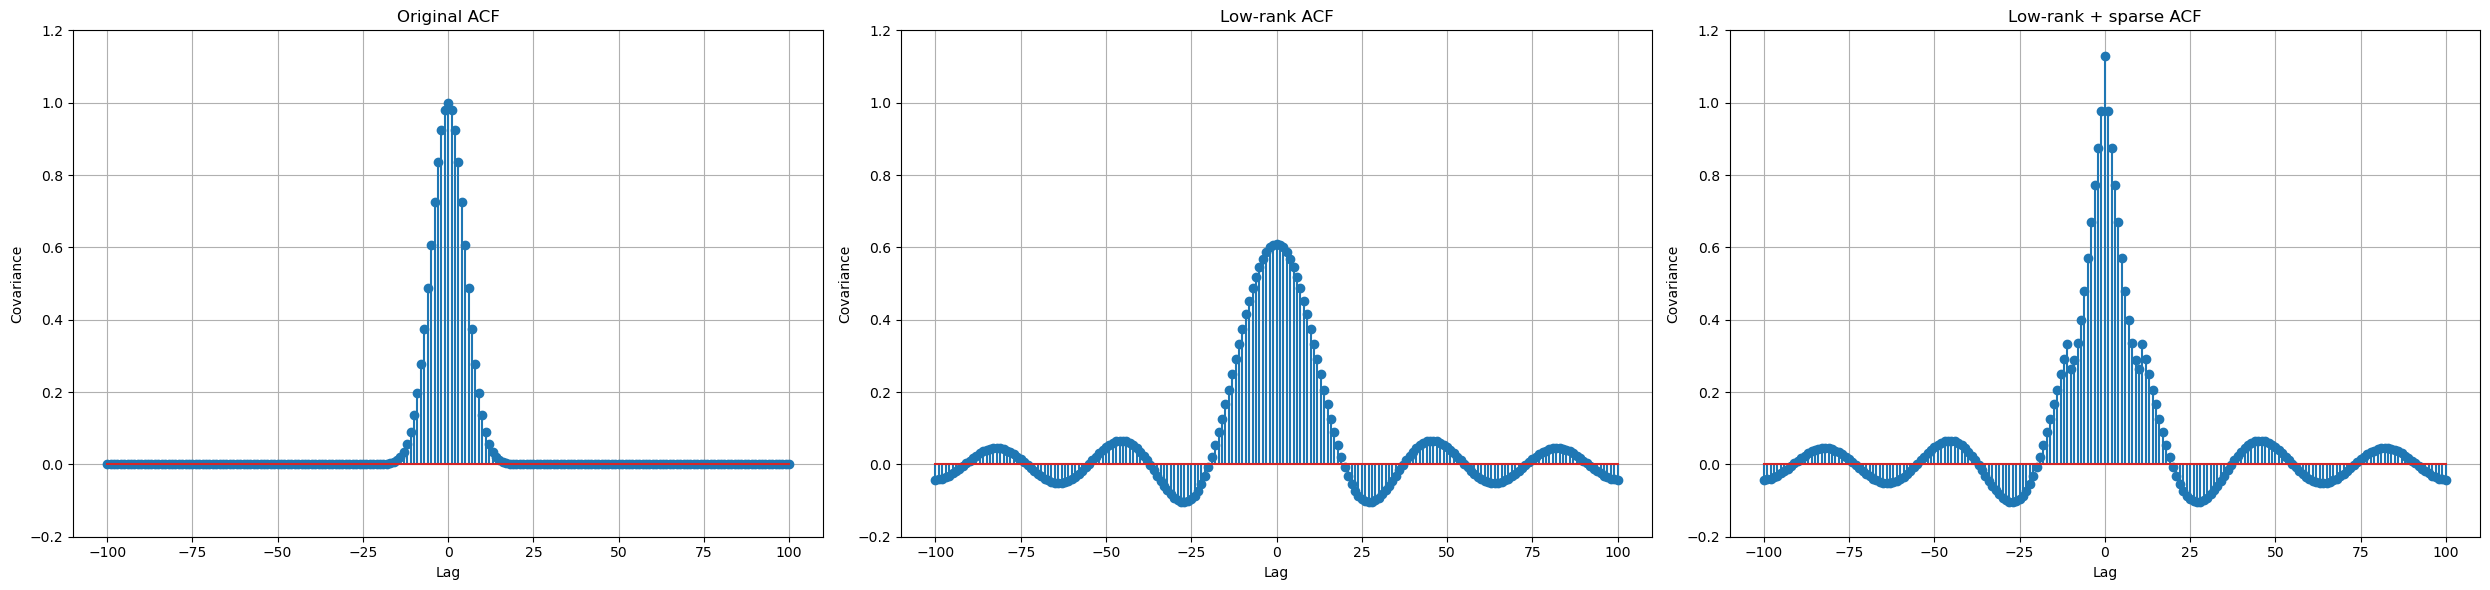

In [81]:
k_rec = k_lr + k_s

fig, ax = plt.subplots(1, 3, figsize=(25, 6))
ylim = (-0.2, 1.2)
stem_plot(ax[0], lags, k, "Original ACF", "Lag", "Covariance", ylim)
stem_plot(ax[1], lags, k_lr, "Low-rank ACF", "Lag", "Covariance", ylim)
stem_plot(ax[2], lags, k_rec, "Low-rank + sparse ACF", "Lag", "Covariance", ylim)
plt.tight_layout()

We can also see how the residual plots compare.

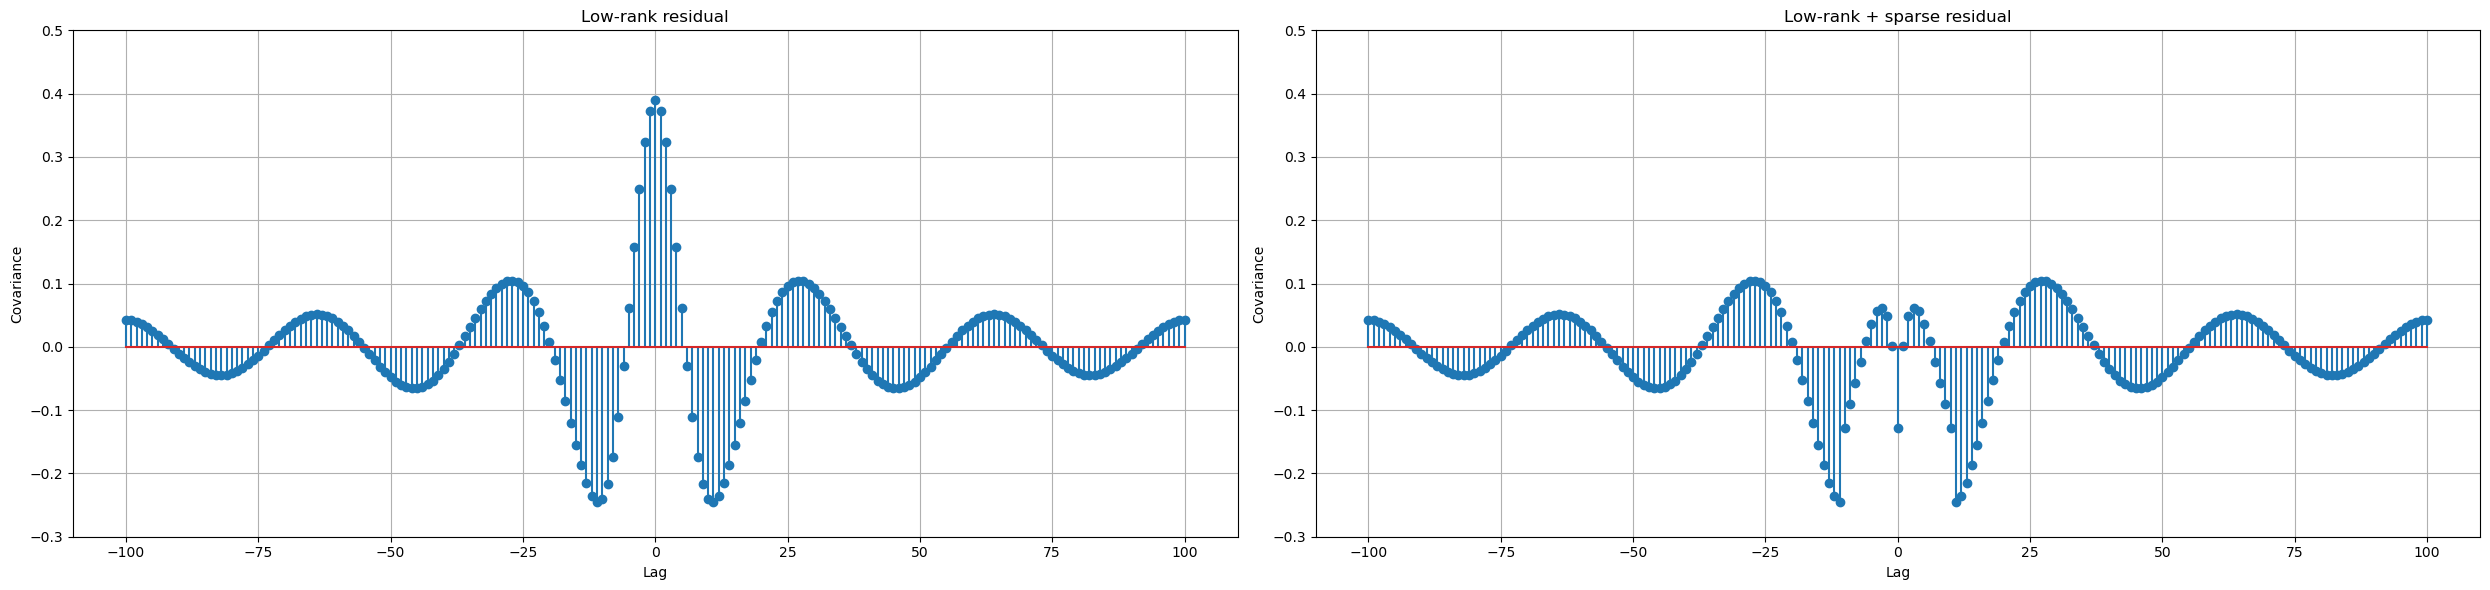

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(25, 6))
ylim = (-0.3, 0.5)
stem_plot(ax[0], lags, k_res, "Low-rank residual", "Lag", "Covariance", ylim)
stem_plot(ax[1], lags, k - k_rec, "Low-rank + sparse residual", "Lag", "Covariance", ylim)
plt.tight_layout()

# Full procedure

> TODO: add description.

In [83]:
def LR_approx(k, r):
    """
    Parameters
    ----------
    k : Centered ACF.
    r : Number of modes.

    Returns
    -------
    Low-rank approximation of k using r modes.
    """
    # Take DFT
    spectrum_shifted = np.real(np.fft.fft(np.fft.ifftshift(k)))

    # Mask the DFT
    lr_spectrum_shifted = spectrum_shifted.copy()
    lr_spectrum_shifted[lr_spectrum_shifted < np.sort(lr_spectrum_shifted)[-r]] = 0

    # Return the inverse of masked DFT
    return np.fft.fftshift(np.real(np.fft.ifft(lr_spectrum_shifted)))

In [84]:
k = [0] * N
for tau in range(T + 1):
    k[T + tau] = k[T - tau] = np.exp(-0.5 * (tau / lengthscale) ** 2)

r = 11
q = 10

rounds = 20
k_stacked = np.zeros((rounds, N))

k_s = np.zeros(N)

for it in range(rounds):
    k_lr = LR_approx(k - k_s, r)
    k_s = MA_approx(k - k_lr, q)
    k_stacked[it, :] = k_lr + k_s

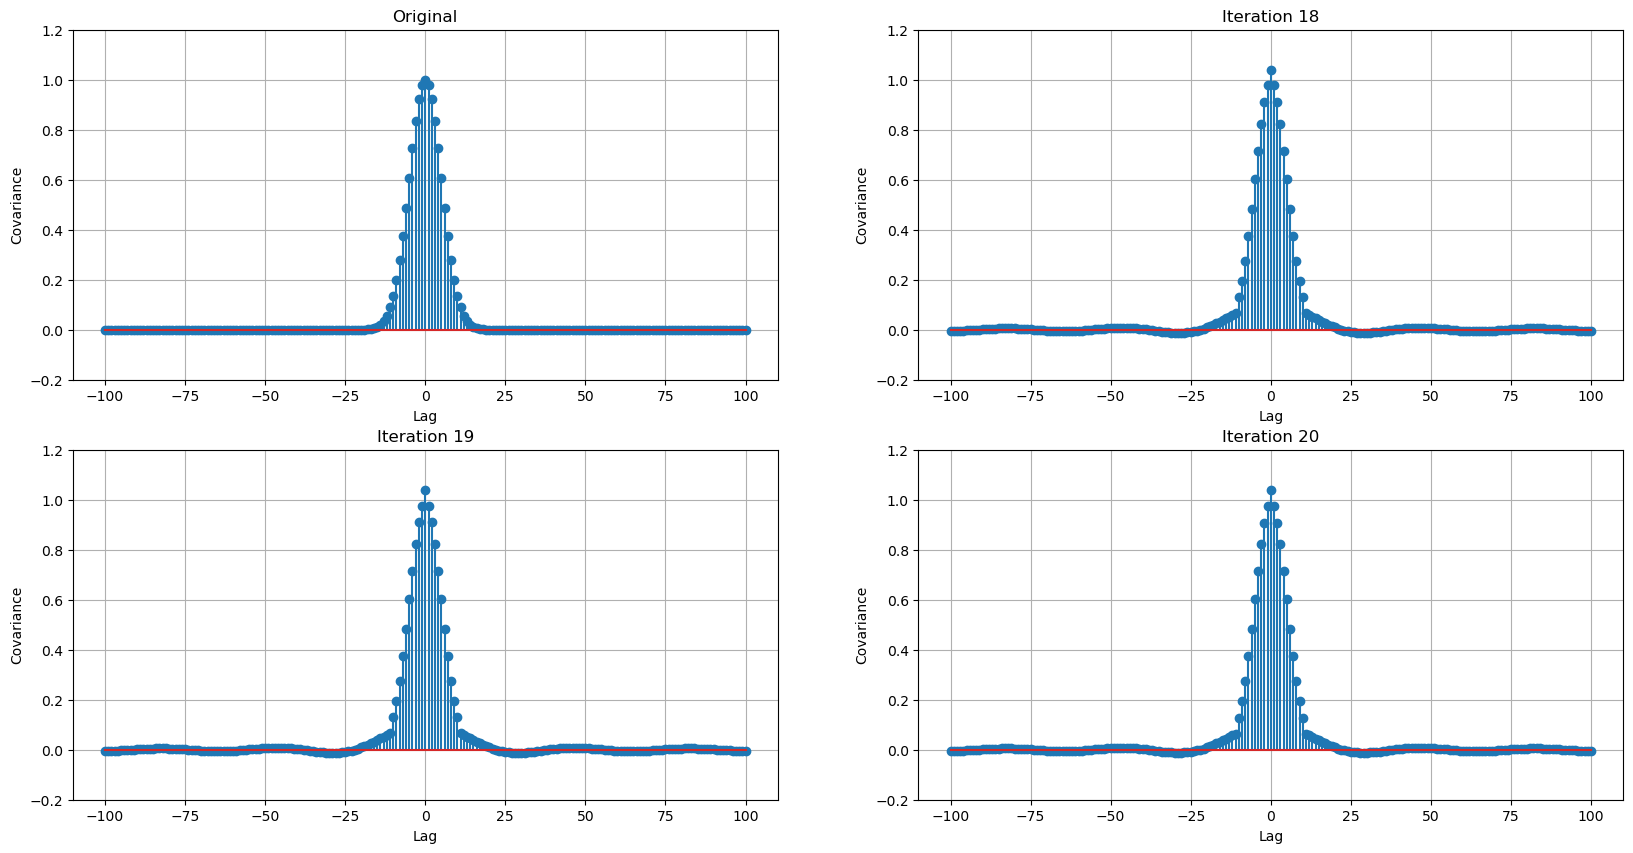

In [85]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
ylim = (-0.2, 1.2)
stem_plot(ax[0][0], lags, k, "Original", "Lag", "Covariance", ylim)
stem_plot(ax[0][1], lags, k_stacked[rounds-3,:], f"Iteration {rounds-2}", "Lag", "Covariance", ylim)
stem_plot(ax[1][0], lags, k_stacked[rounds-2,:], f"Iteration {rounds-1}", "Lag", "Covariance", ylim)
stem_plot(ax[1][1], lags, k_stacked[rounds-1,:], f"Iteration {rounds}", "Lag", "Covariance", ylim)

In [86]:
for it in range(rounds):
    print(f"Error in iteration {it+1}: {np.linalg.norm(k - k_stacked[it, :])}")

Error in iteration 1: 0.9780362676188922
Error in iteration 2: 0.8048825885014509
Error in iteration 3: 0.6672206050432262
Error in iteration 4: 0.5540529089268971
Error in iteration 5: 0.4612972277738331
Error in iteration 6: 0.3856051726682388
Error in iteration 7: 0.3242177092331778
Error in iteration 8: 0.2747615649158518
Error in iteration 9: 0.2361727088016585
Error in iteration 10: 0.2063116443074647
Error in iteration 11: 0.18351163864167744
Error in iteration 12: 0.16635196275844494
Error in iteration 13: 0.15360589439435485
Error in iteration 14: 0.14423825168252927
Error in iteration 15: 0.13740290212769934
Error in iteration 16: 0.132432146969304
Error in iteration 17: 0.12881641151192016
Error in iteration 18: 0.12617753984978644
Error in iteration 19: 0.12424072134576754
Error in iteration 20: 0.12280898551056289
